NBA 2023 dataset: (1315, 26)
NBA 2024 dataset: (965, 26)

=== NBA Betting Model Analysis ===
Running threshold analysis with cross-validation...

Evaluating threshold: 0.55
  Processing fold 1/5...
  Processing fold 2/5...
  Processing fold 3/5...
  Processing fold 4/5...
  Processing fold 5/5...
  Avg Accuracy: 0.504, Avg ROI: -3.81%, Avg Games: 182.0

Evaluating threshold: 0.6
  Processing fold 1/5...
  Processing fold 2/5...
  Processing fold 3/5...
  Processing fold 4/5...
  Processing fold 5/5...
  Avg Accuracy: 0.508, Avg ROI: -2.98%, Avg Games: 116.6

Evaluating threshold: 0.65
  Processing fold 1/5...
  Processing fold 2/5...
  Processing fold 3/5...
  Processing fold 4/5...
  Processing fold 5/5...
  Avg Accuracy: 0.480, Avg ROI: -8.29%, Avg Games: 69.6

Evaluating threshold: 0.7
  Processing fold 1/5...
  Processing fold 2/5...
  Processing fold 3/5...
  Processing fold 4/5...
  Processing fold 5/5...
  Avg Accuracy: 0.429, Avg ROI: -18.04%, Avg Games: 37.6

Evaluating thresh

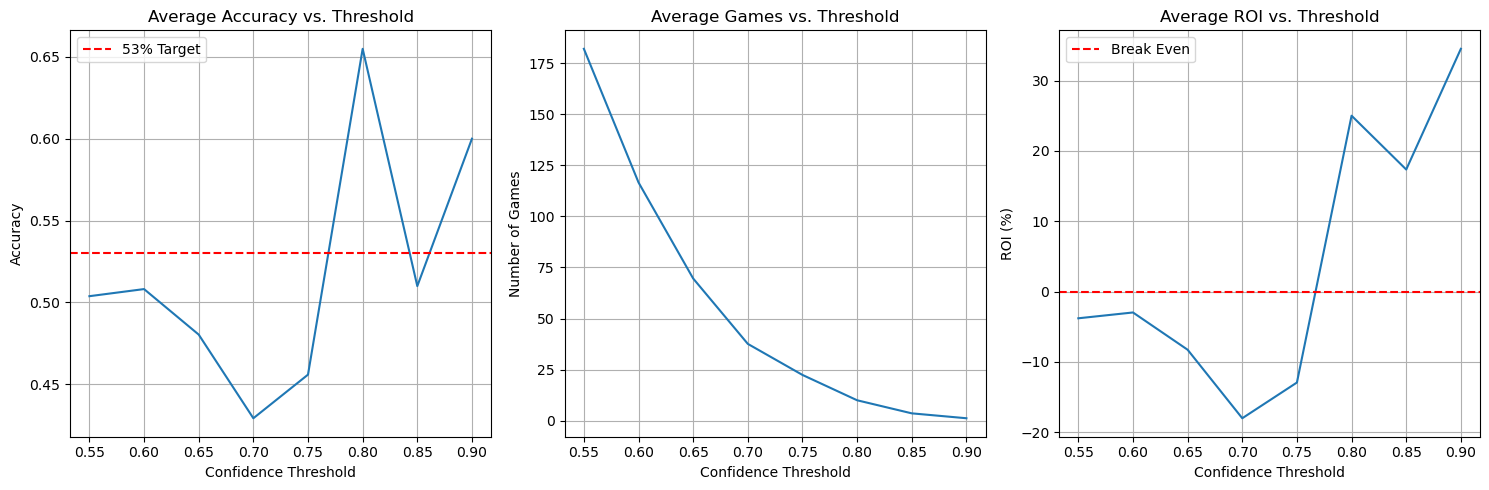


Selected optimal threshold: 0.8
Model saved to nba_betting_model_final.pkl

Evaluating performance on 2024 data with threshold 0.8...
Total predictions: 25 out of 965 games
Accuracy on 2024 data: 0.400
ROI on 2024 data: -23.64%
Total profit with $500 bets: $-2954.55

Monthly performance:
           games  accuracy         roi       profit
yearmonth                                          
2024-10      5.0  0.200000  -61.818182 -1545.454545
2024-11      6.0  0.666667   27.272727   818.181818
2024-12      2.0  1.000000   90.909091   909.090909
2025-01      5.0  0.600000   14.545455   363.636364
2025-02      5.0  0.000000 -100.000000 -2500.000000
2025-03      2.0  0.000000 -100.000000 -1000.000000

Performance by line range:
                  games  accuracy         roi
line_range                                   
Road favored big    2.0  0.000000 -100.000000
Road favored        3.0  0.333333  -36.363636
Road slight fav    11.0  0.454545  -13.223140
Home slight fav     2.0  0.000000 -1

/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_72423/2820540347.py:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_conf['yearmonth'] = high_conf['date'].dt.strftime('%Y-%m')
/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_72423/2820540347.py:349: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_conf['line_range'] = pd.cut(high_conf['line'],
/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_72423/2820540347.py:354: FutureWarning: The default of observed=False is depr

,date,road,home,line,prediction_detail,confidence,predicted_covered,actual_covered
5,2024-10-23,Phoenix,LA Clippers,-5.0,Phoenix to cover as 5.0-point favorite,0.882573,False,True
8,2024-10-23,Milwaukee,Philadelphia,-3.5,Milwaukee to cover as 3.5-point favorite,0.800131,False,False
53,2024-10-29,New Orleans,Golden State,-1.5,New Orleans to cover as 1.5-point favorite,0.935451,False,True
54,2024-10-29,New Orleans,Golden State,-1.5,New Orleans to cover as 1.5-point favorite,0.935451,False,True
60,2024-10-30,New Orleans,Golden State,2.5,New Orleans to cover against 2.5-point home fa...,0.854387,False,True
80,2024-11-01,Oklahoma City,Portland,-11.5,Portland to cover as 11.5-point underdog,0.857059,True,False
151,2024-11-10,Sacramento,Phoenix,-1.0,Sacramento to cover as 1.0-point favorite,0.892249,False,False
163,2024-11-12,New York,Philadelphia,-3.5,New York to cover as 3.5-point favorite,0.892749,False,False
178,2024-11-15,Washington,Atlanta,9.0,Washington to cover against 9.0-point home fav...,0.817541,False,True
179,2024-11-15,Chicago,Cleveland,10.0,Cleveland to cover as 10.0-point favorite,0.802627,True,True


In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
import pickle
import matplotlib.pyplot as plt

# Load the NBA data
data_2023 = pd.read_csv('nba23.csv')
data_2024 = pd.read_csv('nba24.csv')

print(f"NBA 2023 dataset: {data_2023.shape}")
print(f"NBA 2024 dataset: {data_2024.shape}")

# Function to train model
def train_betting_model(train_data):
    """Train a new betting model on the provided training data."""
    # Data preprocessing
    data_clean = train_data.copy()
    
    # Convert date to datetime
    data_clean['date'] = pd.to_datetime(data_clean['date'], format='%m/%d/%Y')
    data_clean['month'] = data_clean['date'].dt.month
    data_clean['day_of_week'] = data_clean['date'].dt.dayofweek
    
    # Create target variable
    data_clean['home_margin'] = data_clean['hscore'] - data_clean['rscore']
    data_clean['home_covered'] = np.where(
        data_clean['line'] > 0,
        data_clean['home_margin'] > data_clean['line'],  # Home is favored
        data_clean['home_margin'] > data_clean['line']   # Road is favored
    )
    
    # Define good line columns
    good_line_columns = [
        'line', 'lineavg', 'linemoore', 'lineopen', 'linedok', 
        'linetalis', 'linemassey', 'linepugh', 'lineespn', 'lineround'
    ]
    
    # Calculate derived features
    data_clean['line_movement'] = data_clean['line'] - data_clean['lineopen']
    data_clean['line_std'] = data_clean[good_line_columns].std(axis=1)
    data_clean['consensus_line'] = data_clean[['linemassey', 'linemoore', 'lineavg']].mean(axis=1)
    data_clean['line_value'] = data_clean['line'] - data_clean['consensus_line']
    
    for col in ['lineavg', 'linemoore', 'linemassey']:
        data_clean[f'{col}_diff'] = data_clean['line'] - data_clean[col]
    
    # Define features
    features = [
        'line', 'lineavg', 'linemoore', 'linemassey', 'linestd',
        'line_movement', 'line_std', 'line_value',
        'linemassey_diff', 'linemoore_diff', 'lineavg_diff',
        'month', 'day_of_week'
    ]
    
    # Create X and y
    X = data_clean[features]
    y = data_clean['home_covered']
    
    # Define and train model
    model_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ])
    
    model_pipeline.fit(X, y)
    
    return model_pipeline, features

# Function to save model
def save_model(model, filepath="nba_betting_model.pkl"):
    """Save the trained model to a file"""
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filepath}")

# Function to load model
def load_model(filepath="nba_betting_model.pkl"):
    """Load a trained model from a file"""
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    return model

# Function to make predictions
def predict_games(model, games_data, features, threshold=0.75):
    """Make predictions for games using the trained model."""
    # Preprocess the games data
    processed_data = games_data.copy()
    
    # Convert date to datetime
    processed_data['date'] = pd.to_datetime(processed_data['date'], format='%m/%d/%Y')
    processed_data['month'] = processed_data['date'].dt.month
    processed_data['day_of_week'] = processed_data['date'].dt.dayofweek
    
    # Define good line columns
    good_line_columns = [
        'line', 'lineavg', 'linemoore', 'lineopen', 'linedok', 
        'linetalis', 'linemassey', 'linepugh', 'lineespn', 'lineround'
    ]
    
    # Calculate derived features
    processed_data['line_movement'] = processed_data['line'] - processed_data['lineopen']
    processed_data['line_std'] = processed_data[good_line_columns].std(axis=1)
    processed_data['consensus_line'] = processed_data[['linemassey', 'linemoore', 'lineavg']].mean(axis=1)
    processed_data['line_value'] = processed_data['line'] - processed_data['consensus_line']
    
    for col in ['lineavg', 'linemoore', 'linemassey']:
        processed_data[f'{col}_diff'] = processed_data['line'] - processed_data[col]
    
    # Ensure all required features are present
    for feature in features:
        if feature not in processed_data.columns:
            processed_data[feature] = 0  # Default to 0 if missing
    
    # Get features for prediction
    X = processed_data[features]
    
    # Make predictions
    try:
        pred_proba = model.predict_proba(X)
        predictions = model.predict(X)
        
        # Add predictions to results
        results = processed_data.copy()
        results['predicted_covered'] = predictions
        results['confidence'] = np.max(pred_proba, axis=1)
        results['p_covered'] = pred_proba[:, 1]
        results['bet'] = results['confidence'] >= threshold
        
        # Add prediction details
        def get_prediction_detail(row):
            line = row['line']
            if row['predicted_covered'] == 1:  # Model predicts cover
                if line > 0:
                    return f"{row['home']} to cover as {line}-point favorite"
                else:
                    return f"{row['home']} to cover as {abs(line)}-point underdog"
            else:  # Model predicts no cover
                if line > 0:
                    return f"{row['road']} to cover against {line}-point home favorite"
                else:
                    return f"{row['road']} to cover as {abs(line)}-point favorite"
        
        results['prediction_detail'] = results.apply(get_prediction_detail, axis=1)
        
        return results
    
    except Exception as e:
        print(f"Error making predictions: {e}")
        print("Feature shapes:", X.shape)
        print("Features head:", X.head())
        print("Missing values in features:", X.isnull().sum())
        return None

# Run cross-validation to find the optimal threshold
def run_threshold_analysis(data):
    print("Running threshold analysis with cross-validation...")
    
    # Convert date to datetime and sort data
    data_sorted = data.copy()
    data_sorted['date'] = pd.to_datetime(data_sorted['date'], format='%m/%d/%Y')
    data_sorted = data_sorted.sort_values('date')
    
    # Define fold indices based on dates
    fold_size = len(data_sorted) // 5
    fold_indices = []
    for i in range(5):
        if i < 4:
            test_indices = list(range(i * fold_size, (i + 1) * fold_size))
        else:
            test_indices = list(range(i * fold_size, len(data_sorted)))
        train_indices = [j for j in range(len(data_sorted)) if j not in test_indices]
        fold_indices.append((train_indices, test_indices))
    
    # Test multiple confidence thresholds
    thresholds = [0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]
    threshold_results = []

    for threshold in thresholds:
        print(f"\nEvaluating threshold: {threshold}")
        cv_results = []
        
        for fold, (train_index, test_index) in enumerate(fold_indices):
            print(f"  Processing fold {fold+1}/5...")
            
            # Split data
            train_data = data_sorted.iloc[train_index].copy()
            test_data = data_sorted.iloc[test_index].copy()
            
            # Train model
            fold_model, features = train_betting_model(train_data)
            
            # Make predictions with current threshold
            predictions = predict_games(fold_model, test_data, features, threshold=threshold)
            
            # Calculate metrics
            if predictions is not None and 'bet' in predictions.columns and sum(predictions['bet']) > 0:
                high_conf = predictions[predictions['bet']].copy()
                high_conf.loc[:, 'home_margin'] = high_conf['hscore'] - high_conf['rscore']
                high_conf.loc[:, 'actual_covered'] = np.where(
                    high_conf['line'] > 0,
                    high_conf['home_margin'] > high_conf['line'],
                    high_conf['home_margin'] > high_conf['line']
                )
                
                if len(high_conf) > 0:
                    correct = sum(high_conf['predicted_covered'] == high_conf['actual_covered'])
                    accuracy = correct / len(high_conf)
                    roi = (correct * 100 - (len(high_conf) - correct) * 110) / (len(high_conf) * 110) * 100
                else:
                    accuracy = 0
                    roi = 0
                    
                cv_results.append({
                    'fold': fold + 1,
                    'high_conf_games': len(high_conf),
                    'accuracy': accuracy,
                    'roi': roi
                })
            else:
                cv_results.append({
                    'fold': fold + 1,
                    'high_conf_games': 0,
                    'accuracy': 0,
                    'roi': 0
                })
        
        # Calculate average metrics across folds
        cv_df = pd.DataFrame(cv_results)
        avg_accuracy = cv_df['accuracy'].mean()
        avg_roi = cv_df['roi'].mean()
        avg_games = cv_df['high_conf_games'].mean()
        
        # Store results for this threshold
        threshold_results.append({
            'threshold': threshold,
            'avg_accuracy': avg_accuracy,
            'avg_roi': avg_roi,
            'avg_games': avg_games,
            'folds_with_bets': sum(cv_df['high_conf_games'] > 0)
        })
        
        print(f"  Avg Accuracy: {avg_accuracy:.3f}, Avg ROI: {avg_roi:.2f}%, Avg Games: {avg_games:.1f}")

    # Convert to DataFrame and display results
    threshold_df = pd.DataFrame(threshold_results)
    print("\nPerformance at different thresholds (cross-validated):")
    print(threshold_df)

    # Find the best threshold based on ROI
    valid_thresholds = threshold_df[threshold_df['avg_games'] >= 5]  # Require at least 5 games on average
    if len(valid_thresholds) > 0:
        best_threshold = valid_thresholds.loc[valid_thresholds['avg_roi'].idxmax(), 'threshold']
        best_performance = valid_thresholds.loc[valid_thresholds['avg_roi'].idxmax()]
        
        print("\nBest threshold based on ROI (with at least 5 games/fold):")
        print(f"Threshold: {best_threshold}")
        print(f"Average Accuracy: {best_performance['avg_accuracy']:.3f}")
        print(f"Average ROI: {best_performance['avg_roi']:.2f}%")
        print(f"Average Games: {best_performance['avg_games']:.1f}")
        
        # Create visualizations
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(threshold_df['threshold'], threshold_df['avg_accuracy'])
        plt.axhline(y=0.53, color='r', linestyle='--', label='53% Target')
        plt.title('Average Accuracy vs. Threshold')
        plt.xlabel('Confidence Threshold')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.legend()
        
        plt.subplot(1, 3, 2)
        plt.plot(threshold_df['threshold'], threshold_df['avg_games'])
        plt.title('Average Games vs. Threshold')
        plt.xlabel('Confidence Threshold')
        plt.ylabel('Number of Games')
        plt.grid(True)
        
        plt.subplot(1, 3, 3)
        plt.plot(threshold_df['threshold'], threshold_df['avg_roi'])
        plt.axhline(y=0, color='r', linestyle='--', label='Break Even')
        plt.title('Average ROI vs. Threshold')
        plt.xlabel('Confidence Threshold')
        plt.ylabel('ROI (%)')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        return best_threshold
    else:
        print("\nNo threshold meets the minimum games requirement")
        return 0.75  # Default threshold

# Function to evaluate model on the 2024 data
def evaluate_2024_performance(model, features, optimal_threshold):
    print(f"\nEvaluating performance on 2024 data with threshold {optimal_threshold}...")
    
    # Make predictions on 2024 data
    predictions_2024 = predict_games(model, data_2024, features, threshold=optimal_threshold)
    
    # Calculate actual results
    predictions_2024['home_margin'] = predictions_2024['hscore'] - predictions_2024['rscore']
    predictions_2024['actual_covered'] = np.where(
        predictions_2024['line'] > 0,
        predictions_2024['home_margin'] > predictions_2024['line'],
        predictions_2024['home_margin'] > predictions_2024['line']
    )
    
    # Get high confidence predictions
    high_conf = predictions_2024[predictions_2024['bet']]
    
    print(f"Total predictions: {len(high_conf)} out of {len(predictions_2024)} games")
    
    if len(high_conf) > 0:
        correct = sum(high_conf['predicted_covered'] == high_conf['actual_covered'])
        accuracy = correct / len(high_conf)
        roi = (correct * 100 - (len(high_conf) - correct) * 110) / (len(high_conf) * 110) * 100
        
        print(f"Accuracy on 2024 data: {accuracy:.3f}")
        print(f"ROI on 2024 data: {roi:.2f}%")
        print(f"Total profit with $500 bets: ${(roi/100) * 500 * len(high_conf):.2f}")
        
        # Monthly breakdown
        high_conf['yearmonth'] = high_conf['date'].dt.strftime('%Y-%m')
        monthly = high_conf.groupby('yearmonth').apply(
            lambda x: pd.Series({
                'games': len(x),
                'accuracy': sum(x['predicted_covered'] == x['actual_covered']) / len(x),
                'roi': (sum(x['predicted_covered'] == x['actual_covered']) * 100 - 
                       (len(x) - sum(x['predicted_covered'] == x['actual_covered'])) * 110) / (len(x) * 110) * 100,
                'profit': (sum(x['predicted_covered'] == x['actual_covered']) * 100 - 
                          (len(x) - sum(x['predicted_covered'] == x['actual_covered'])) * 110) / 110 * 500
            })
        )
        
        print("\nMonthly performance:")
        print(monthly)
        
        # Line range breakdown
        high_conf['line_range'] = pd.cut(high_conf['line'], 
                                       bins=[-50, -10, -5, 0, 5, 10, 50],
                                       labels=['Road favored big', 'Road favored', 'Road slight fav', 
                                               'Home slight fav', 'Home favored', 'Home favored big'])
        
        line_perf = high_conf.groupby('line_range').apply(
            lambda x: pd.Series({
                'games': len(x),
                'accuracy': sum(x['predicted_covered'] == x['actual_covered']) / len(x),
                'roi': (sum(x['predicted_covered'] == x['actual_covered']) * 100 - 
                       (len(x) - sum(x['predicted_covered'] == x['actual_covered'])) * 110) / (len(x) * 110) * 100
            })
        )
        
        print("\nPerformance by line range:")
        print(line_perf)
        
        return predictions_2024, high_conf
    else:
        print("No games met the confidence threshold")
        return predictions_2024, None

# Main execution
print("\n=== NBA Betting Model Analysis ===")

# 1. Run cross-validation to find optimal threshold
optimal_threshold = run_threshold_analysis(data_2023)
print(f"\nSelected optimal threshold: {optimal_threshold}")

# 2. Train the final model on all 2023 data
final_model, features = train_betting_model(data_2023)
save_model(final_model, 'nba_betting_model_final.pkl')

# 3. Evaluate performance on 2024 data
predictions_2024, high_conf_bets = evaluate_2024_performance(final_model, features, optimal_threshold)

# 4. Summarize findings
if high_conf_bets is not None and len(high_conf_bets) > 0:
    print("\n=== Summary of NBA Betting Model ===")
    print(f"Model trained on {len(data_2023)} games from 2023")
    print(f"Evaluated on {len(data_2024)} games from 2024")
    print(f"Using confidence threshold of {optimal_threshold}")
    print(f"Made {len(high_conf_bets)} high-confidence predictions")
    print(f"Accuracy: {sum(high_conf_bets['predicted_covered'] == high_conf_bets['actual_covered']) / len(high_conf_bets):.3f}")
    roi = (sum(high_conf_bets['predicted_covered'] == high_conf_bets['actual_covered']) * 100 - 
           (len(high_conf_bets) - sum(high_conf_bets['predicted_covered'] == high_conf_bets['actual_covered'])) * 110) / (len(high_conf_bets) * 110) * 100
    print(f"ROI: {roi:.2f}%")
    print(f"Total profit with $500 bets: ${(roi/100) * 500 * len(high_conf_bets):.2f}")
    
    # Display sample of recommended bets
    print("\nSample of high confidence bets:")
    display(high_conf_bets[['date', 'road', 'home', 'line', 'prediction_detail', 'confidence', 
                            'predicted_covered', 'actual_covered']].head(10))